In [1]:
%matplotlib inline
import os
import sys
import platform
import matplotlib
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as tick
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime,timedelta
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

Print specs of major packages and system

In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(matplotlib.__version__))

Operating System Windows 7
Python Version 2.7.8 (default, Jun 30 2014, 16:03:49) [MSC v.1500 32 bit (Intel)]
Pandas Version 0.17.1
Numpy Version 1.10.4
Matplotlib Version 1.5.1


Set data location

In [3]:
if platform.system() == 'Windows':
    drive = 'M:'
else:
    drive = '/media/p/Transcend/'
outputFolder = drive + '/GIS/'
raw_archive_folder = drive + '/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive'

Import custom scripts and connection info

In [4]:
# custom functions for transducer data import
import Snake_Valley_Data_Import as svdi
import wellapplication as wa
USGS = wa.usgs()

# Get and Modify Data From Database

Skip if you don't need fresh data

Create Query to get list of wells

In [9]:
# get connection info for MySQL database
sys.path.append(raw_archive_folder)
import engineGetter
engine = engineGetter.getEngine()

In [ ]:
quer = "SELECT * FROM groundwater.well WHERE WellID <= 75 OR WellID = 136"
g = pd.read_sql_query(sql=quer,con=engine)
wells = list(g['WellID'].values)

In [ ]:
g.to_clipboard()

Use well list to populate a dictionary of water level elevation

In [ ]:
wellData = {}
for well in wells:
    quer = "SELECT DateTime, WaterElevation FROM groundwater.reading where WellID = " + str(int(well)) + " AND DateTime >= '2009'"
    wellData[well] = pd.read_sql_query(sql=quer, con=engine, parse_dates='DateTime', index_col = 'DateTime')

In [ ]:
for well in wells:
    wellData[well] = wellData[well].resample('6H')
    wellData[well] = wellData[well].interpolate()
    mean = wellData[well]['WaterElevation'].mean()
    std = wellData[well]['WaterElevation'].std()
    wellData[well]['avgDiffWL'] = wellData[well]['WaterElevation'] - mean
    wellData[well]['stdWL'] = wellData[well]['avgDiffWL']/std

Resample hourly water level data to monthly and daily values.

In [ ]:
AllHourly = pd.concat(wellData)
AllHourly.reset_index(inplace=True)
AllHourly.set_index('DateTime',inplace=True)
AllHourly.rename(columns={'level_0':'site_no','WaterElevation':'lev_va'}, inplace=True)
AllHourly['year'] = AllHourly.index.year
AllHourly['month'] = AllHourly.index.month
AllHourly['doy'] = AllHourly.index.dayofyear
AllHourly['diff'] = AllHourly['lev_va'].diff()

In [ ]:
AllHourly.to_csv(outputFolder + "QuarterDayUGSdata.csv")

# Upload Data You Saved Earlier

In [5]:
df = pd.read_csv(outputFolder + "halfDayUGSdata.csv", low_memory=False, 
                 index_col='DateTime', parse_dates=True)
g = pd.read_csv(outputFolder+'SitesWQualifier.csv')
wells = list(g['WellID'].values)

In [6]:
df.columns

Index([u'site_no', u'lev_va', u'avgDiffWL', u'stdWL', u'year', u'month',
       u'doy', u'diff'],
      dtype='object')

In [7]:
siteDict = pd.Series(g['MonType'].values,index = g['WellID']).to_dict()
df['MonType'] = df['site_no'].apply(lambda x: siteDict[x],1)

In [10]:
wellid = {}

for well in g.WellID:
    wellid[well] = g[g['WellID'] == well]['Well'].values[0]

In [11]:
df['julian'] = df.index.to_julian_date()

# Monthly and Seasonal Trend Plots

In [8]:
def monthlyPlot(df, grp, data, title):
    grpd = df.groupby([grp])[data]
    x = grpd.median().index
    y = grpd.median()
    y1 = grpd.quantile(q=0.25)
    y2 = grpd.quantile(q=0.75)
    y3 = grpd.quantile(q=0.1)
    y4 = grpd.quantile(q=0.9)
    
    n = plt.figure()
    plt.plot(x, y, 'bo-',color = 'blue', label = 'Median', )
    plt.fill_between(x,y2,y1,alpha=0.2, label = '25-75%-tiles', color = 'green')
    plt.fill_between(x,y3,y1,alpha=0.2, color='red', label = '10-90%-tiles')
    plt.fill_between(x,y2,y4,alpha=0.2, color='red')
    if grp == 'month':
        plt.xlim(0,13)
        plt.xticks(range(0,13))
    #plt.ylim(-2.25,2.25)
    #plt.yticks(np.arange(-2.25,2.50,0.25))
        plt.xlabel('month')
    plt.ylabel(title)
    plt.grid()
    plt.legend(loc=3)
    
    return n

TypeDict = {'S':'Wetland Monitoring Sites','P':'Agricultural Monitoring Sites','W':'Sites Outside of Pumping and Evapotranspiration Influence'}


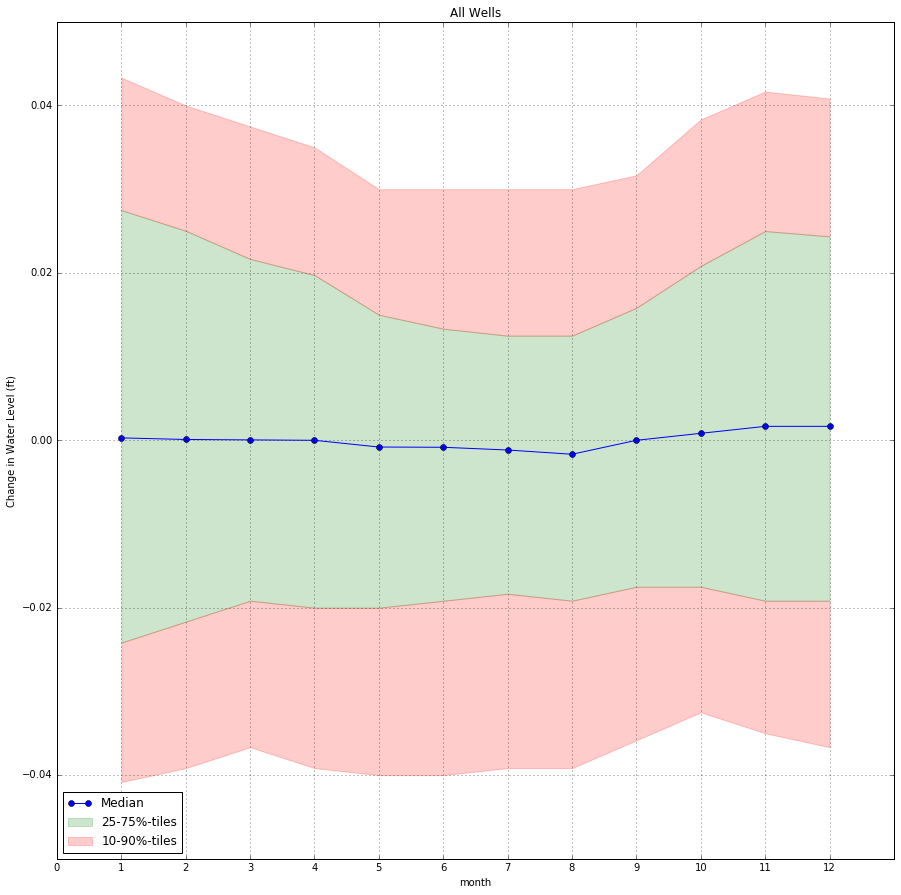

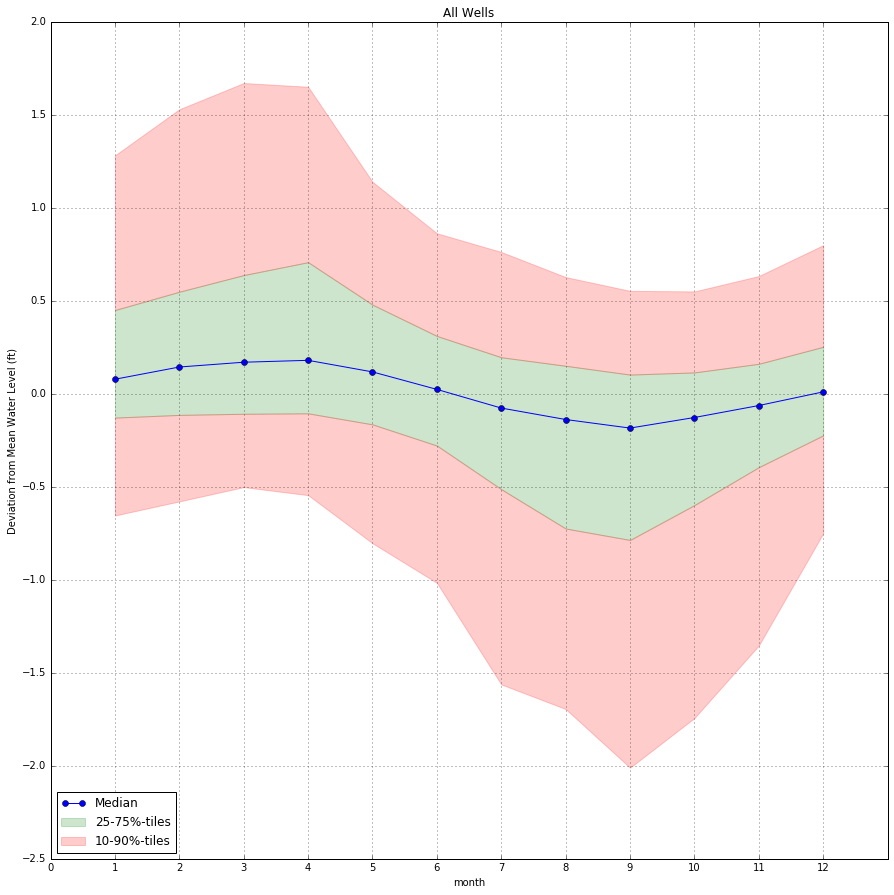

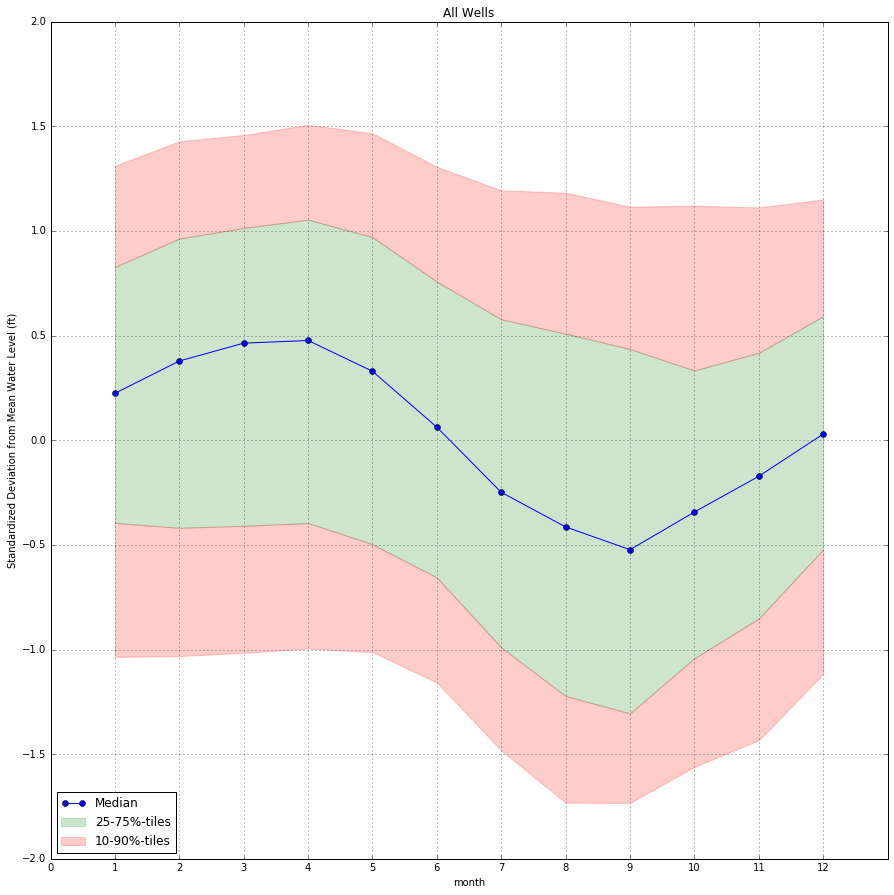

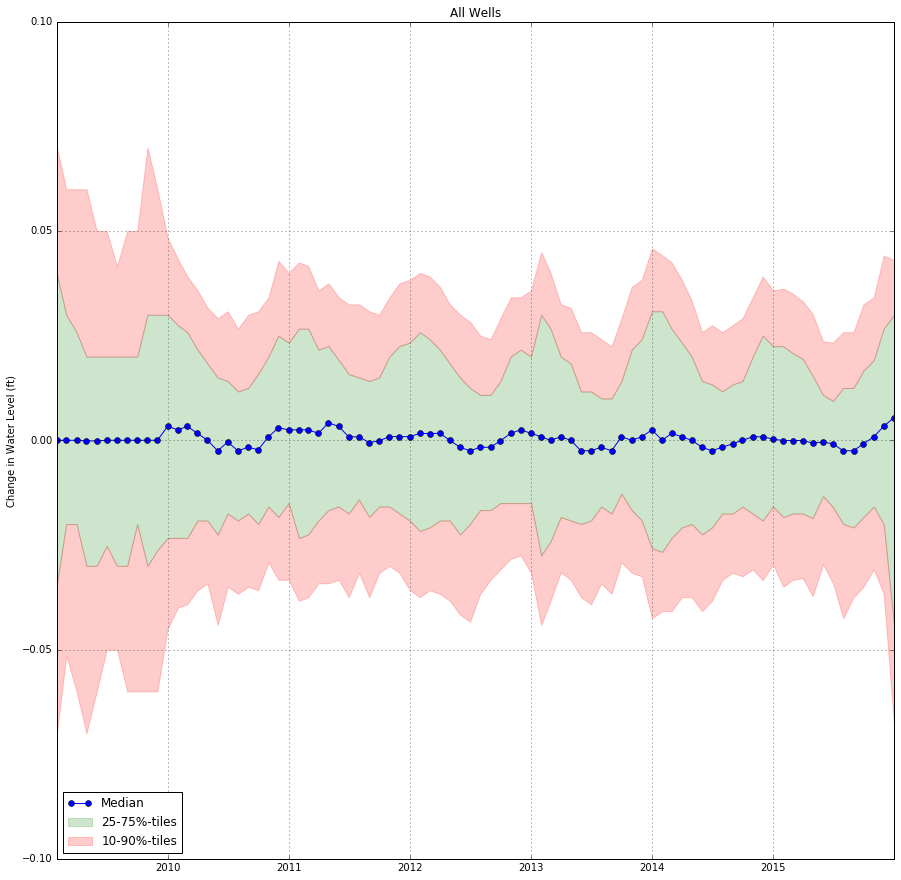

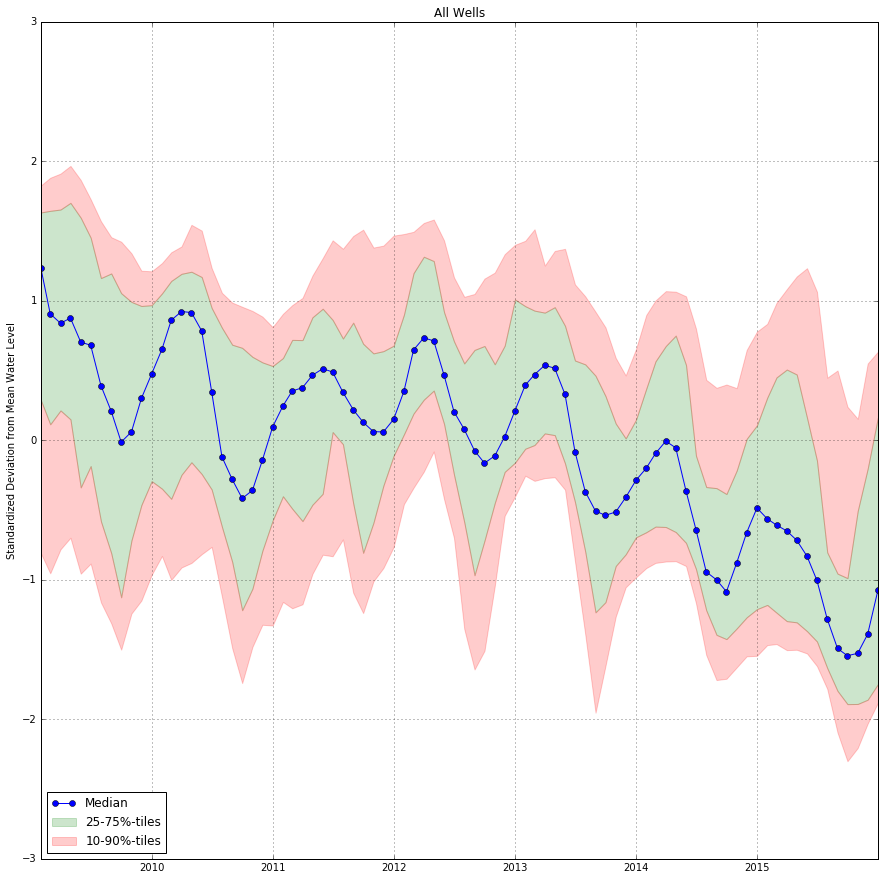

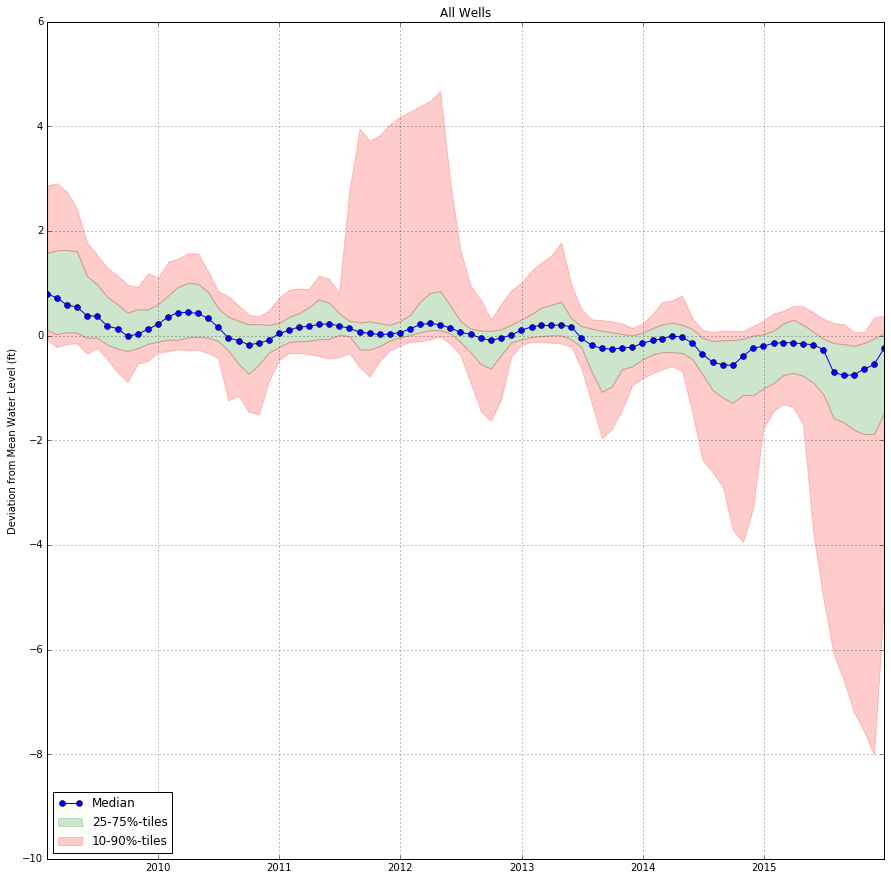

In [9]:
pdf = PdfPages(outputFolder + 'monthly.pdf')
grp = "month"

data = "diff"
title = 'Change in Water Level (ft)'
monthlyPlot(df, grp, data, title)
plt.title('All Wells')
for f, h in df.groupby('MonType'):
    n = monthlyPlot(h, grp, data, title)
    plt.title(TypeDict[f])
    pdf.savefig(n)
    plt.close()

data = 'avgDiffWL'
title = 'Deviation from Mean Water Level (ft)'
monthlyPlot(df, grp, data, title)
plt.title('All Wells')
for f, h in df.groupby('MonType'):
    n = monthlyPlot(h, grp, data, title)
    plt.title(TypeDict[f])
    pdf.savefig(n)
    plt.close()
    
data = 'stdWL'
title = 'Standardized Deviation from Mean Water Level (ft)'
monthlyPlot(df, grp, data, title)
plt.title('All Wells')
for f, h in df.groupby('MonType'):
    n = monthlyPlot(h, grp, data, title)
    plt.title(TypeDict[f])
    pdf.savefig(n)
    plt.close()
    
grp = pd.TimeGrouper("M")
data = "diff"
title = 'Change in Water Level (ft)'
monthlyPlot(df, grp, data, title)
plt.title('All Wells')
plt.ylim(-0.1,0.1)
for f, h in df.groupby('MonType'):
    n = monthlyPlot(h, grp, data, title)
    plt.ylim(-0.1,0.1)
    plt.title(TypeDict[f])
    pdf.savefig(n)
    plt.close()
    
grp = pd.TimeGrouper("M")
data = "stdWL"
title = 'Standardized Deviation from Mean Water Level'
monthlyPlot(df, grp, data, title)
plt.ylim(-3,3)
plt.title('All Wells')
for f, h in df.groupby('MonType'):
    n = monthlyPlot(h, grp, data, title)
    plt.title(TypeDict[f])
    plt.ylim(-3,3)
    pdf.savefig(n)
    plt.close()
    
grp = pd.TimeGrouper("M")
data = 'avgDiffWL'
title = 'Deviation from Mean Water Level (ft)'
monthlyPlot(df, grp, data, title)
plt.title('All Wells')
for f, h in df.groupby('MonType'):
    n = monthlyPlot(h, grp, data, title)
    plt.title(TypeDict[f])
    pdf.savefig(n)
    plt.close()
    
pdf.close()

# Regression to Raw Data

In [12]:
def RLM(svws, site):
    '''
    RETURNS
    x0, slope, x_prime, y_hat, wellId, wellName, montype
    '''
    
    x0 = svws[site]['julian']
    y = svws[site]['lev_va']

    x = sm.add_constant(x0)
    data = svws[site]['lev_va'].to_frame()

    est = sm.RLM(y, x).fit()
    wellId = site
    slope = est.params[1]
    wellName = wellid[site]
    montype = siteDict[site]
    x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)
    
    return x0, y, slope, x_prime, y_hat, wellId, wellName, montype

def OLS(svws, site):
    '''
    RETURNS
    x0, slope, x_prime, y_hat, wellId, wellName, montype
    '''
    
    x0 = svws[site]['julian']
    y = svws[site]['lev_va']

    x = sm.add_constant(x0)
    data = svws[site]['lev_va'].to_frame()

    est = sm.OLS(y, x).fit()
    wellId = site
    slope = est.params[1]
    wellName = wellid[site]
    montype = siteDict[site]
    x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)
    rsqrd = (round(float(est.rsquared),2))
    
    return x0, y, slope, x_prime, y_hat, wellId, wellName, montype, rsqrd

In [13]:
pdf = PdfPages(outputFolder + 'OLSRLM.pdf')

pivTab = df.dropna(subset=['lev_va'])

siteList = list(pivTab.site_no.unique())
svws = {}
svwsEarly = {}
svwsLate = {}
svwsPiv = {}

RLMslope, RLMslope_er, RLMslope_lt, OLSslope, OLSslope_er, OLSslope_lt = [],[],[],[],[],[]

OLSrsqrd, OLSrsqrd_er, OLSrsqrd_lt = [], [], []

wellName, wellId, montype = [], [], []

for site in siteList:
    #fig = plt.figure(figsize=(20,10))
    svws[site] = pivTab[pivTab.site_no == site]
    svwsEarly[site] = svws[site][svws[site].index < pd.datetime(2011,5,1)]
    svwsLate[site] = svws[site][svws[site].index > pd.datetime(2012,5,1)]
    
    n = plt.figure(wellid[site])
    
    x0, y, slope, x_prime, y_hat, wellId1, wellName1, montype1 = RLM(svws, site)
    plt.scatter(x0,y)
    plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='RLM fit m= ' + str(slope))
    RLMslope.append(slope)
    
    x0, y, slope, x_prime, y_hat, wellId1, wellName1, montype1 = RLM(svwsEarly, site)
    plt.scatter(x0,y, label='early')
    plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='RLM fit Early m= ' + str(slope))
    RLMslope_er.append(slope)

    x0, y, slope, x_prime, y_hat, wellId1, wellName1, montype1 = RLM(svwsLate, site)
    plt.scatter(x0,y, label='late')
    plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='RLM fit Late m= ' + str(slope))
    RLMslope_lt.append(slope)
    
    x0, y, slope, x_prime, y_hat, wellId1, wellName1, montype1, rsqrd = OLS(svws, site)
    #plt.scatter(x0,y)
    #plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit m= ' + str(slope))
    OLSslope.append(slope)
    OLSrsqrd.append(rsqrd)
    
    x0, y, slope, x_prime, y_hat, wellId1, wellName1, montype1, rsqrd = OLS(svwsEarly, site)
    #plt.scatter(x0,y, label='early')
    #plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit Early m= ' + str(slope))
    OLSslope_er.append(slope)
    OLSrsqrd_er.append(rsqrd)
    
    x0, y, slope, x_prime, y_hat, wellId, wellName, montype, rsqrd
    x0, y, slope, x_prime, y_hat, wellId1, wellName1, montype1, rsqrd = OLS(svwsLate, site)
    #plt.scatter(x0,y, label='late')
    #plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit Late m= ' + str(slope))
    OLSslope_lt.append(slope)
    OLSrsqrd_lt.append(rsqrd)
    
    wellId.append(wellId1)    
    wellName.append(wellName1)
    montype.append(montype1)

    plt.legend()
    plt.title(str(wellid[site]))
    plt.xlabel('Julian Day')
    plt.ylabel('Discharge (gpm)')
    plt.grid()
    plt.tight_layout()
    pdf.savefig(n)
    plt.close()
pdf.close()    

In [14]:
RLMOLS = pd.DataFrame({'RLM slope (ft/day)':RLMslope, 'RLM slope early (ft/day)':RLMslope_er, 'RLM slope late (ft/day)':RLMslope_lt, 
              'OLS slope (ft/day)':OLSslope, 'OLS slope early (ft/day)':OLSslope_er, 'OLS slope late (ft/day)':OLSslope_lt , 
             'OLS r-squared':OLSrsqrd, 'OLS r-squared early':OLSrsqrd_er, 'OLS r-squared late':OLSrsqrd_lt, 
             'Well Name':wellName, 'Well ID':wellId, 'Monitoring Type':montype})
RLMOLS[u'RLM slope (ft/yr)'] = RLMOLS[u'RLM slope (ft/day)'] * 365.25
RLMOLS[u'OLS slope (ft/yr)'] = RLMOLS[u'OLS slope (ft/day)'] * 365.25

In [15]:
RLMOLS.groupby('Monitoring Type')['OLS slope (ft/yr)'].agg({'min':np.min, 'mean':np.mean,'median':np.median,
                                                        'max':np.max, 'std':np.std, 'cnt':(lambda x: np.count_nonzero(~np.isnan(x)))}).reset_index()


Monitoring Type       std  cnt       min       max    median      mean
0               P  0.482057   27 -1.667593 -0.011758 -0.416859 -0.590087
1               S  0.058530   17 -0.098835  0.129458 -0.024602 -0.011464
2               W  0.174813   32 -0.544534  0.210549 -0.032956 -0.088056

# Seasonal Decomposition

In [89]:
pdf = PdfPages(outputFolder + 'decompose.pdf')

svws = {}
for site in siteList:  
    svws[site] = pivTab[pivTab.site_no == site]
    data = svws[site]['lev_va']
    res =  sm.tsa.seasonal_decompose(data.values, freq=365*4+1)
    plt.figure(wellid[site])
    resplot = res.plot()
    pdf.savefig(resplot)
    plt.close()

pdf.close()

MemoryError: In RendererAgg: Out of memory

Error in callback <function post_execute at 0x06496730> (for post_execute):


MemoryError: In RendererAgg: Out of memory

MemoryError: In RendererAgg: Out of memory

In [102]:
resData = {}
seasData = {}
trendData = {}
svws = {}

for site in siteList: 
    svws[site] = pivTab[pivTab.site_no == site]
    data = svws[site]['lev_va']
    sd =  sm.tsa.seasonal_decompose(data.values, freq=365*4+1)
    resData[site] = pd.DataFrame(sd.resid)
    seasData[site] = pd.DataFrame(sd.seasonal)
    trendData[site] = pd.DataFrame(sd.trend)


In [105]:
data

DateTime
2009-04-02 12:00:00    4334.100000
2009-04-03 00:00:00    4334.095090
2009-04-03 12:00:00    4334.090180
2009-04-04 00:00:00    4334.085270
2009-04-04 12:00:00    4334.080360
2009-04-05 00:00:00    4334.075450
2009-04-05 12:00:00    4334.070541
2009-04-06 00:00:00    4334.065631
2009-04-06 12:00:00    4334.060721
2009-04-07 00:00:00    4334.055811
2009-04-07 12:00:00    4334.050901
2009-04-08 00:00:00    4334.045991
2009-04-08 12:00:00    4334.041081
2009-04-09 00:00:00    4334.036171
2009-04-09 12:00:00    4334.031261
2009-04-10 00:00:00    4334.026351
2009-04-10 12:00:00    4334.021441
2009-04-11 00:00:00    4334.016532
2009-04-11 12:00:00    4334.011622
2009-04-12 00:00:00    4334.006712
2009-04-12 12:00:00    4334.001802
2009-04-13 00:00:00    4333.996892
2009-04-13 12:00:00    4333.991982
2009-04-14 00:00:00    4333.987072
2009-04-14 12:00:00    4333.982162
2009-04-15 00:00:00    4333.977252
2009-04-15 12:00:00    4333.972342
2009-04-16 00:00:00    4333.967432
2009-04-16 

In [90]:
residuals = pd.concat(resData)
seasonals = pd.concat(seasData)
trends = pd.concat(trendData)

TypeError: cannot concatenate a non-NDFrame object

In [17]:
#pdf = PdfPages(outputFolder + 'decompose.pdf')
%matplotlib inline
svws = {}

for site in siteList[0:5]:
    plt.figure(wellid[site])
    svws[site] = pivTab[pivTab.site_no == site]
    data = svws[site]['lev_va']
    res = sm.tsa.periodogram(data.values)
    print(res)
    plt.show()
    


[    0.          9626.80850209  1358.88302985 ...,  3201.57049647
  1358.88302985  9626.80850209]


[     0.          11072.83490339   1384.95704937 ...,   3665.7054972
   1384.95704937  11072.83490339]


[     0.          38392.43843419  33655.77484051 ...,  10665.41635713
  33655.77484051  38392.43843419]


[  0.          65.94812023  27.27599679 ...,  34.495211    27.27599679
  65.94812023]


[  0.          29.11898149   7.63897146 ...,  31.79771266   7.63897146
  29.11898149]


In [18]:
print(len(svws[site]['lev_va']))

4970


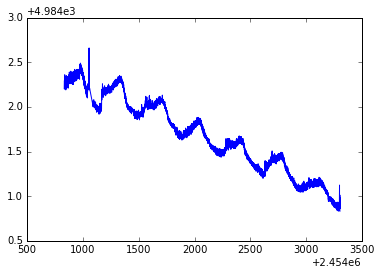

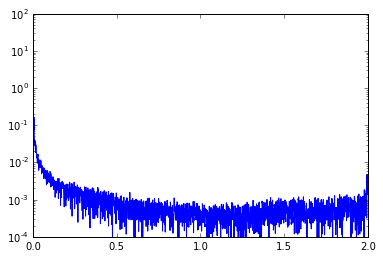

In [18]:
import scipy.fftpack
site=21
# Number of samplepoints
svws[site] = pivTab[pivTab.site_no == site]
N = len(svws[site]['lev_va'])
# sample spacing
F = 4.0 # samples per day - sample rate
T = 1.0 / F # sample interval - 1 day per 4 samples 
x = svws[site]['julian'].values
y = svws[site]['lev_va'].values
plt.plot(x,y)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N/2]))
plt.ylim(1E-4,1E2)
plt.yscale('log')
#plt.xlim(0,0.05)
plt.show()

# Color Hydros

In [26]:
pdf = PdfPages(outputFolder + 'ColorHydros.pdf')

pivTab = dfs[['year','doy','lev_va','site_no']]
siteList = list(pivTab.site_no.unique())

svws = {}
svwsPiv = {}

for site in siteList:
    fig = plt.figure(figsize=(20,10))
    svws[site] = pivTab[pivTab.site_no == site]
    svwsPiv[site] = svws[site].pivot("year", "doy", "lev_va")
    sns.heatmap(svwsPiv[site], robust=True, cmap="jet_r", fmt="d")
    plt.xticks(np.arange(0,370,30),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)
    plt.xlabel("Day of Calendar Year")
    plt.title(wellid[site])
    pdf.savefig(fig)
    plt.close()

pdf.close()

ImportError: No module named seab

In [ ]:
pieData = pd.read_excel("U:/GWP/Wetland/WaterMonitoring/PiezometerData/Compiled/SVPiezoDailyAverages2009-Dec2014.xlsx")
pieData['year'] = pieData['Date'].apply(lambda x: int(x.year),1)
pieData.reset_index(inplace=True)
pieData.set_index('Date',inplace=True)
pieData['doy'] = pieData.index.dayofyear

pdf = PdfPages(outputFolder + 'piezometers.pdf')

colms = list(pieData.columns)

svws = {}
svwsPiv = {}

for site in colms:
    if 'Water Elevation' in site:
        fig = plt.figure(figsize=(20,10))
        svws[site] = pieData[['doy','year', site]]      
        svws[site].drop_duplicates(subset = ['year','doy'], inplace=True)
        svwsPiv[site] = svws[site].pivot("year", "doy", site)
        sns.heatmap(svwsPiv[site], robust=True, cmap="jet_r", fmt="d")
        plt.xticks(np.arange(0,370,10), np.arange(0,370,10), rotation=90)
        plt.xlabel("Day of Calendar Year")
        plt.title(site)
        pdf.savefig(fig)
        plt.close()
        
pdf.close()

# Climate Data

Hals = http://wcc.sc.egov.usda.gov/nwcc/site?sitenum=2164 <br>
Tule = http://wcc.sc.egov.usda.gov/nwcc/site?sitenum=2163 <br>
Whlr = http://wcc.sc.egov.usda.gov/nwcc/site?sitenum=1147 <br>

In [19]:
HalsSCAN = {}
TuleSCAN = {}
WhlrSNOTEL = {}

# import multiple files downloaded from respective sites
for i in range(2010,2017):
    HalsSCAN[i] = pd.read_csv(outputFolder + '2164_ALL_YEAR='+str(int(i))+'.csv', skiprows=3, 
                              parse_dates={'dt':[1,2]}, index_col='dt', na_values=-99.9)
    TuleSCAN[i] = pd.read_csv(outputFolder + '2163_ALL_YEAR='+str(int(i))+'.csv', skiprows=3, 
                              parse_dates={'dt':[1,2]}, index_col='dt', na_values=-99.9)
    WhlrSNOTEL[i] = pd.read_csv(outputFolder + '1147_ALL_YEAR='+str(int(i))+'.csv', skiprows=3,
                                parse_dates={'dt':[1,2]}, index_col='dt', na_values=-99.9)
    

    
Hals = pd.concat(HalsSCAN)
Tule = pd.concat(TuleSCAN)
Whlr = pd.concat(WhlrSNOTEL)

Whlr.reset_index(inplace=True)
Whlr.set_index('dt', inplace=True)
Tule.reset_index(inplace=True)
Tule.set_index('dt', inplace=True)
Hals.reset_index(inplace=True)
Hals.set_index('dt', inplace=True)

Whlr.drop(Whlr.columns[0],inplace=True,axis=1)
Tule.drop(Tule.columns[0],inplace=True,axis=1)
Hals.drop(Hals.columns[0],inplace=True,axis=1)

WhlrDaily = Whlr.resample('D', how='mean')
TuleDaily = Tule.resample('D', how='mean')
HalsDaily = Hals.resample('D', how='mean')

In [20]:
HW = pd.merge(Hals, Whlr, left_index=True, right_index=True)
HWT = pd.merge(HW, Tule, left_index=True, right_index=True)

In [21]:
WTD = pd.merge(WhlrDaily,TuleDaily, left_index=True, right_index=True)
WTH = pd.merge(WTD,HalsDaily, left_index=True, right_index=True)

In [22]:
Eskd = pd.read_csv(outputFolder + 'UCC_ghcn_USC00422607_2016_03_28_1459219796.csv', skiprows=15, parse_dates={'dt':[0]}, 
                   index_col='dt', na_values='M')
Eskd['Eskd Precipitation'] = pd.to_numeric(Eskd['Precipitation'], errors='coerce')
Eskd['Eskd Snow Depth'] = pd.to_numeric(Eskd['Snow Depth'], errors='coerce')
Eskd['Eskd Snow Fall'] = pd.to_numeric(Eskd['Snow Depth'], errors='coerce')
Eskd['Eskd cumdept'] = Eskd['Eskd Precipitation'].apply(lambda x: x- Eskd['Eskd Precipitation'].mean()).cumsum()

In [23]:
Part = pd.read_csv(outputFolder + 'UCC_ghcn_USC00426708_2016_03_28_1459222060.csv', skiprows=15, parse_dates={'dt':[0]}, 
                   index_col='dt', na_values='M')
Part['Part Precipitation'] = pd.to_numeric(Part['Precipitation'], errors='coerce')
Part['Part SnowIBEFPC Depth'] = pd.to_numeric(Part['Snow Depth'], errors='coerce')
Part['Part Snow Fall'] = pd.to_numeric(Part['Snow Depth'], errors='coerce')
Part['Part cumdept'] = Part['Part Precipitation'].apply(lambda x: x- Part['Part Precipitation'].mean()).cumsum()

In [24]:
Calo = pd.read_csv(outputFolder + 'UCC_ghcn_USC00421144_2016_03_28_1459222774.csv', skiprows=15, parse_dates={'dt':[0]}, 
                   index_col='dt', na_values='M')
Calo['Calo Precipitation'] = pd.to_numeric(Calo['Precipitation'], errors='coerce')
Calo['Calo Snow Depth'] = pd.to_numeric(Calo['Snow Depth'], errors='coerce')
Calo['Calo Snow Fall'] = pd.to_numeric(Calo['Snow Depth'], errors='coerce')
Calo['Calo cumdept'] = Calo['Calo Precipitation'].apply(lambda x: x- Calo['Calo Precipitation'].mean()).cumsum()
Calo.drop(['Snow Depth','Snow Fall', 'Precipitation'], axis=1, inplace=1)

In [25]:
Fish = pd.read_csv(outputFolder + 'UCC_ghcn_USC00422852_2016_03_28_1459223049.csv', skiprows=15, parse_dates={'dt':[0]}, 
                   index_col='dt', na_values='M')
Fish['Fish Precipitation'] = pd.to_numeric(Fish['Precipitation'], errors='coerce')
Fish['Fish Snow Depth'] = pd.to_numeric(Fish['Snow Depth'], errors='coerce')
Fish['Fish Snow Fall'] = pd.to_numeric(Fish['Snow Depth'], errors='coerce')
Fish['Fish cumdept'] = Fish['Fish Precipitation'].apply(lambda x: x- Fish['Fish Precipitation'].mean()).cumsum()
Fish.drop(['Snow Depth','Snow Fall', 'Precipitation'], axis=1, inplace=1)

In [26]:
IBAH = pd.read_csv(outputFolder + 'UCC_ghcn_USC00424174_2016_03_28_1459224176.csv', skiprows=15, parse_dates={'dt':[0]}, 
                   index_col='dt', na_values='M')
IBAH['IBAH Precipitation'] = pd.to_numeric(IBAH['Precipitation'], errors='coerce')
IBAH['IBAH Snow Depth'] = pd.to_numeric(IBAH['Snow Depth'], errors='coerce')
IBAH['IBAH Snow Fall'] = pd.to_numeric(IBAH['Snow Depth'], errors='coerce')
IBAH['IBAH cumdept'] = IBAH['IBAH Precipitation'].apply(lambda x: x- IBAH['IBAH Precipitation'].mean()).cumsum()

In [27]:
PC = pd.merge(Part,Calo, left_index=True,right_index=True)
EF = pd.merge(Eskd,Fish, left_index=True,right_index=True)
IBEF = pd.merge(IBAH,EF, left_index=True,right_index=True)
IBEFPC = pd.merge(IBEF,PC, left_index=True,right_index=True)

(-25567L, 16801L)

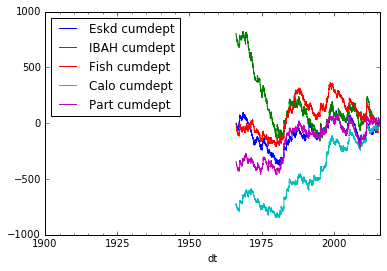

In [28]:
IBEFPC[['Eskd cumdept','IBAH cumdept','Fish cumdept','Calo cumdept','Part cumdept']].plot()
plt.xlim('1/1/1900','1/1/2016')

In [29]:
IBEFPC['avgDept'] = IBEFPC[['Eskd cumdept','IBAH cumdept','Fish cumdept','Calo cumdept','Part cumdept']].mean(axis=1)

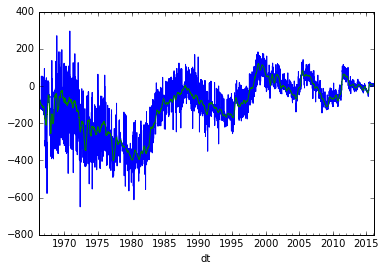

In [30]:
IBEFPC['avgDept'].plot()
IBEFPC['movAvgDept'] = pd.rolling_mean(IBEFPC['avgDept'],100, center=True)
IBEFPC['movAvgDept'].plot()

In [31]:
All = pd.merge(IBEFPC, WTH, left_index=True, right_index=True)

# Correlation

In [32]:
df.columns

Index([u'site_no', u'lev_va', u'avgDiffWL', u'stdWL', u'year', u'month',
       u'doy', u'diff', u'MonType', u'julian'],
      dtype='object')

In [63]:
d = df.pivot(columns='site_no', values='stdWL')

In [64]:
d.dropna(inplace=True)
d = d.resample('1D')
d.interpolate(method='time',inplace=True)

In [52]:
from scipy import signal

In [65]:
d.columns

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
             14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
             27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
             40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
             53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
             66,  67,  68,  69,  70,  71,  72,  73,  74,  75, 136],
           dtype='int64', name=u'site_no')

In [66]:
for col in d.columns:
    d['dt'+str(col)] = signal.detrend(d[col].values)

In [67]:
dp = pd.merge(d, IBEFPC, left_index=True, right_index=True, how='inner')

In [68]:
dp.dropna(inplace=True)
dp = dp.resample('1D')
dp.interpolate(method='time',inplace=True)

In [73]:
useCols = [col for col in d.columns if 'dt' in str(col)]

In [78]:
# use only detrended data
d2 = d.filter(regex='dt')

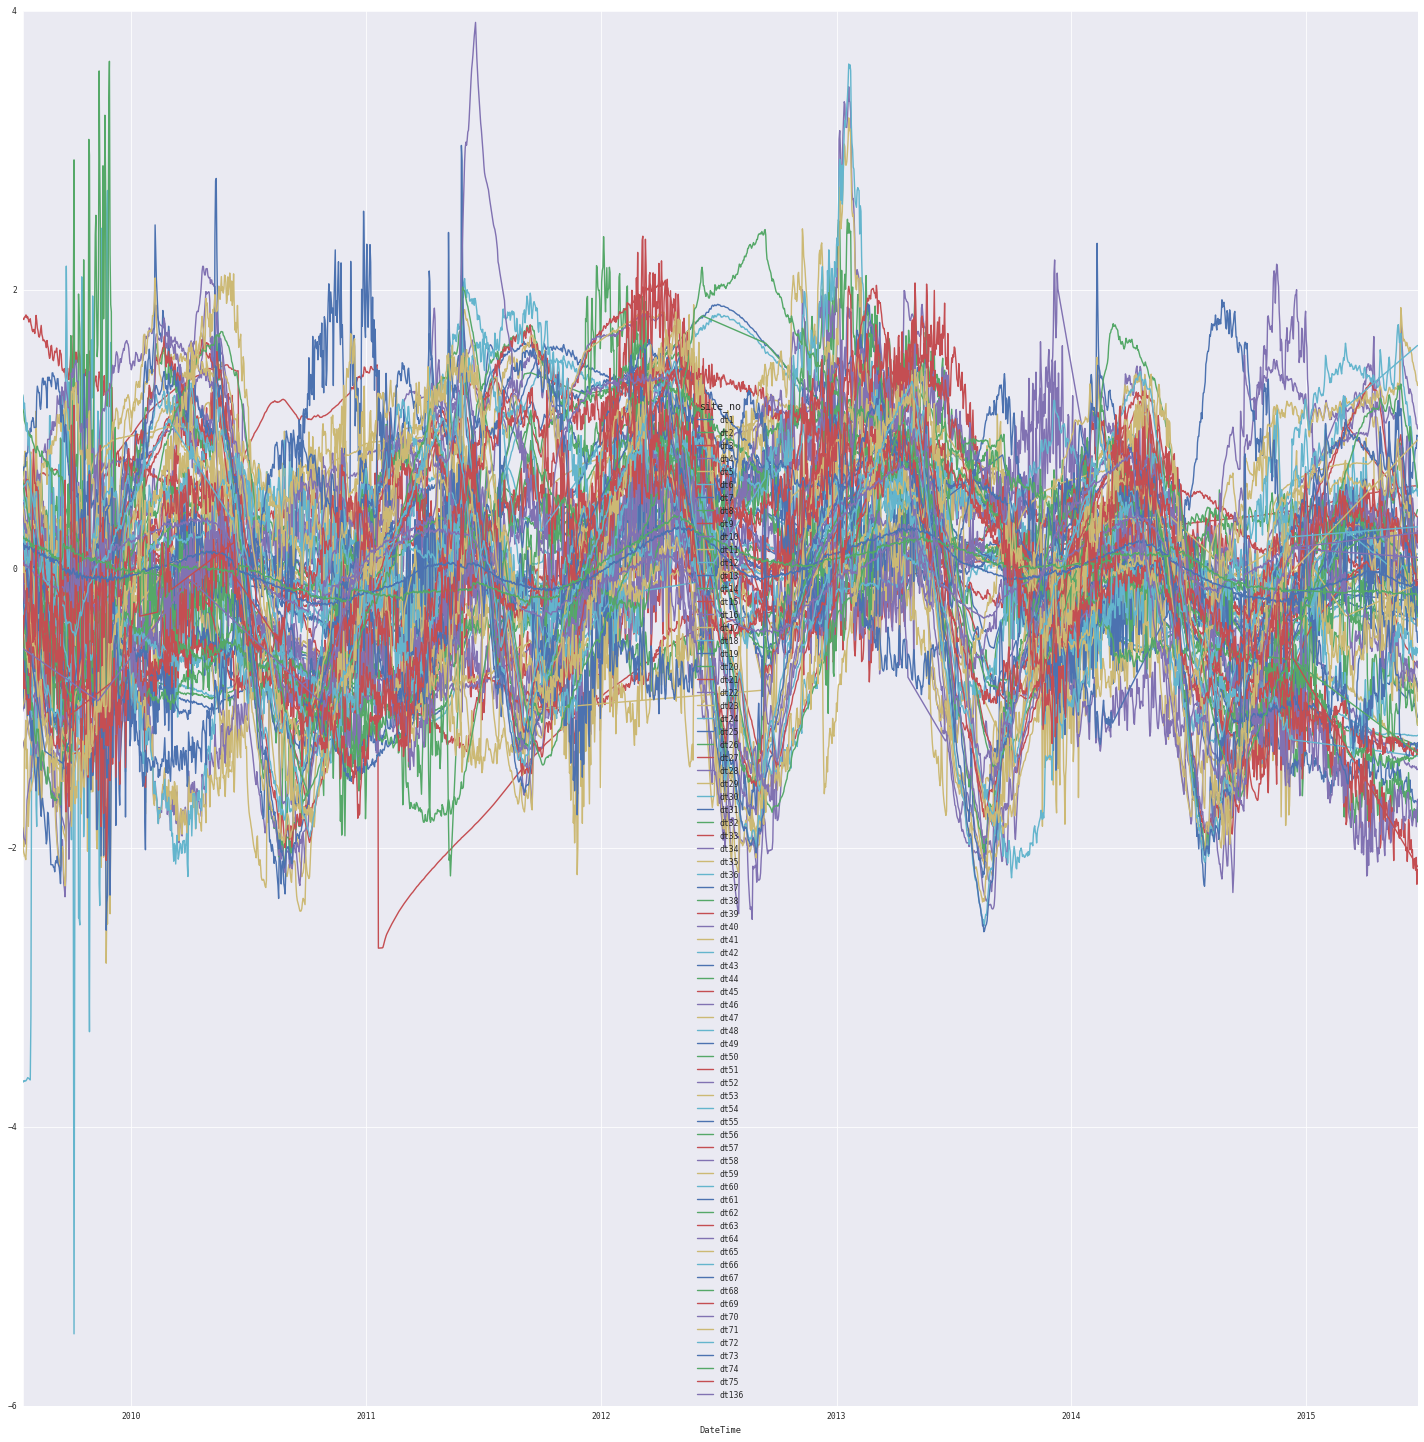

In [81]:
d2.plot()

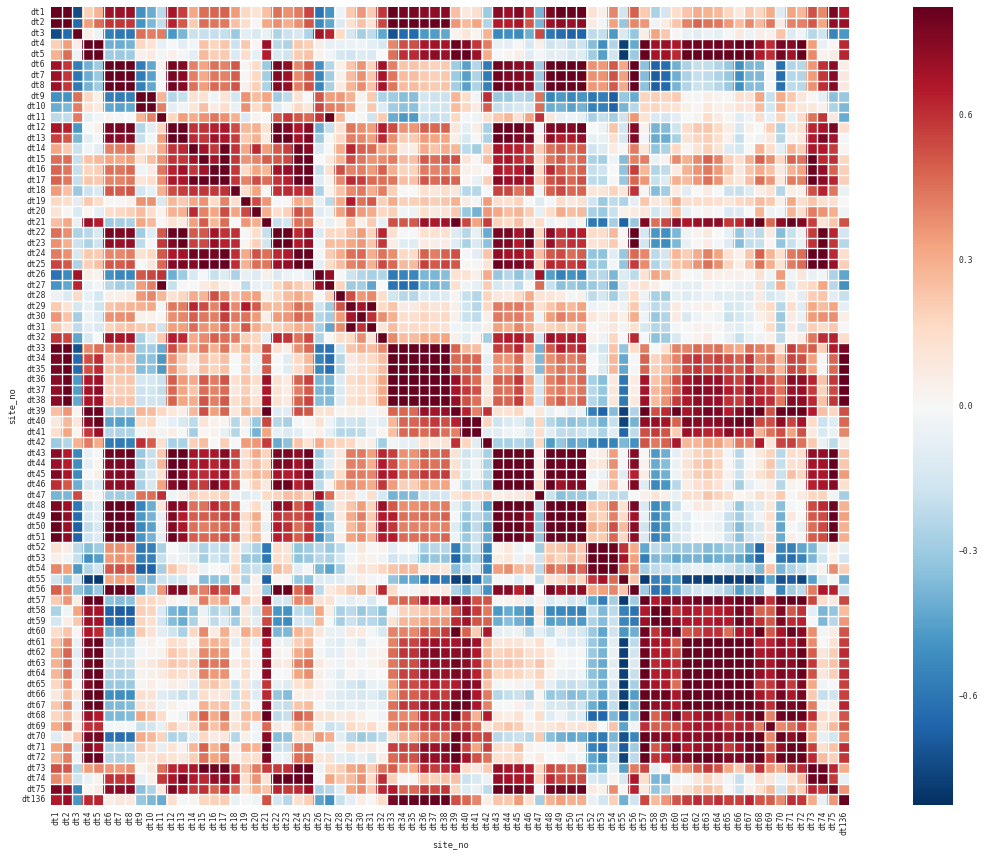

In [77]:
import seaborn as sns

corrmat = d2.corr(method = 'spearman') #default is 'pearson'
sns.set(context="paper", font="monospace")
rcParams['figure.figsize'] = 25, 25
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

# Use matplotlib directly to emphasize known networks
networks = corrmat.columns.get_level_values('site_no')
for i, network in enumerate(networks):
    if i and network != networks[i - 1]:
        ax.axhline(len(networks) - i, c="w")
        ax.axvline(i, c="w")
f.tight_layout()



In [37]:
collist = corrmat.columns
six = {}
eigth = {}
sevfive = {}
for i in collist:
    ssn = corrmat[(corrmat[i] > 0.6) & (corrmat[i]<1.0)].index.tolist()
    esn = corrmat[(corrmat[i] > 0.8) & (corrmat[i]<1.0)].index.tolist()
    sfsn = corrmat[(corrmat[i] > 0.75) & (corrmat[i]<1.0)].index.tolist()
    six[wellid[i]] = [wellid[j] for j in ssn]
    eigth[wellid[i]] = [wellid[j] for j in esn]
    sevfive[wellid[i]] = [wellid[j] for j in sfsn]

In [38]:
pd.DataFrame.from_dict(eigth, orient='index').to_clipboard()

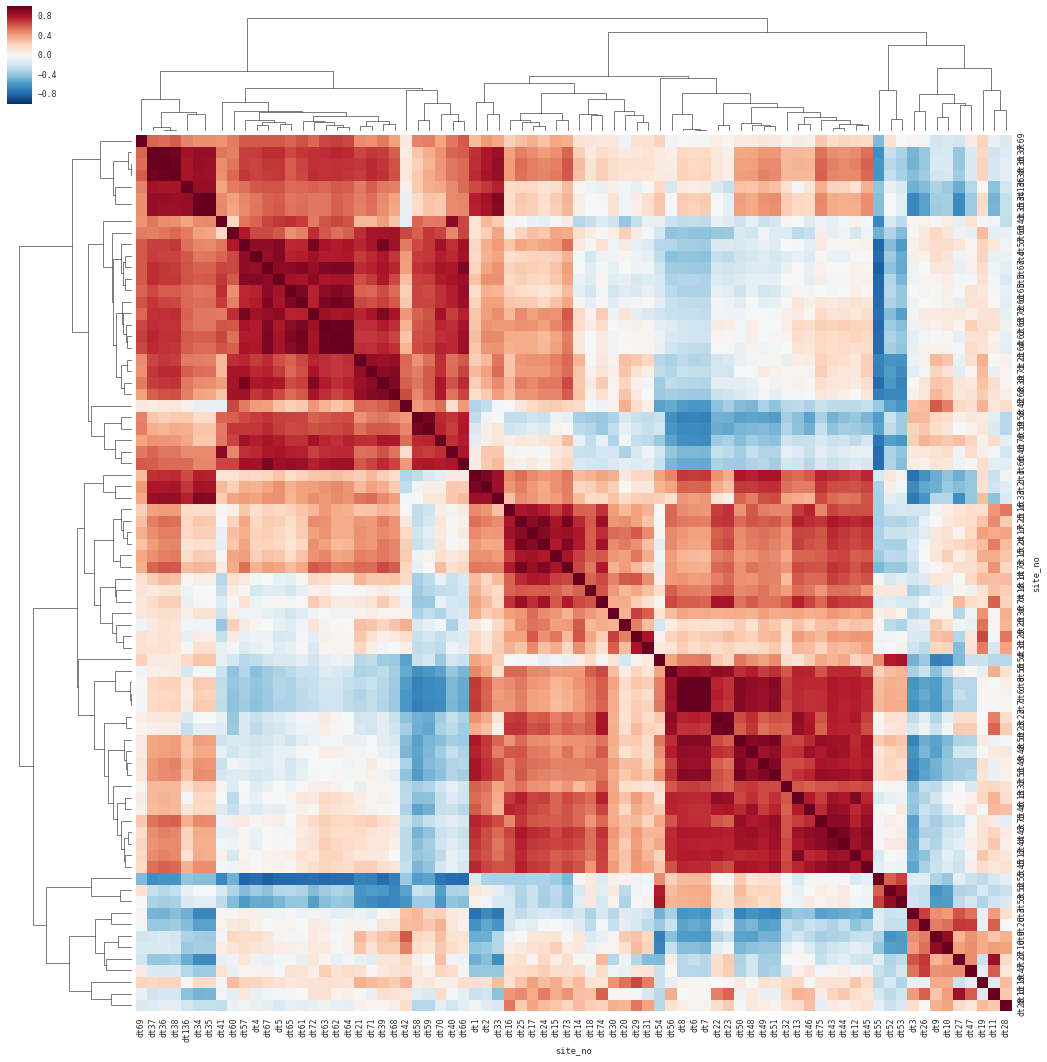

In [82]:
sns.clustermap(d2.corr(method = 'spearman'),figsize=(18, 18))

In [46]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [49]:
%matplotlib inline
#mpl.rcParams.update(mpl.rcParamsDefault)
inline_rc = dict(mpl.rcParams)
mpl.rcParams.update(inline_rc)
rcParams['figure.figsize'] = 15, 15

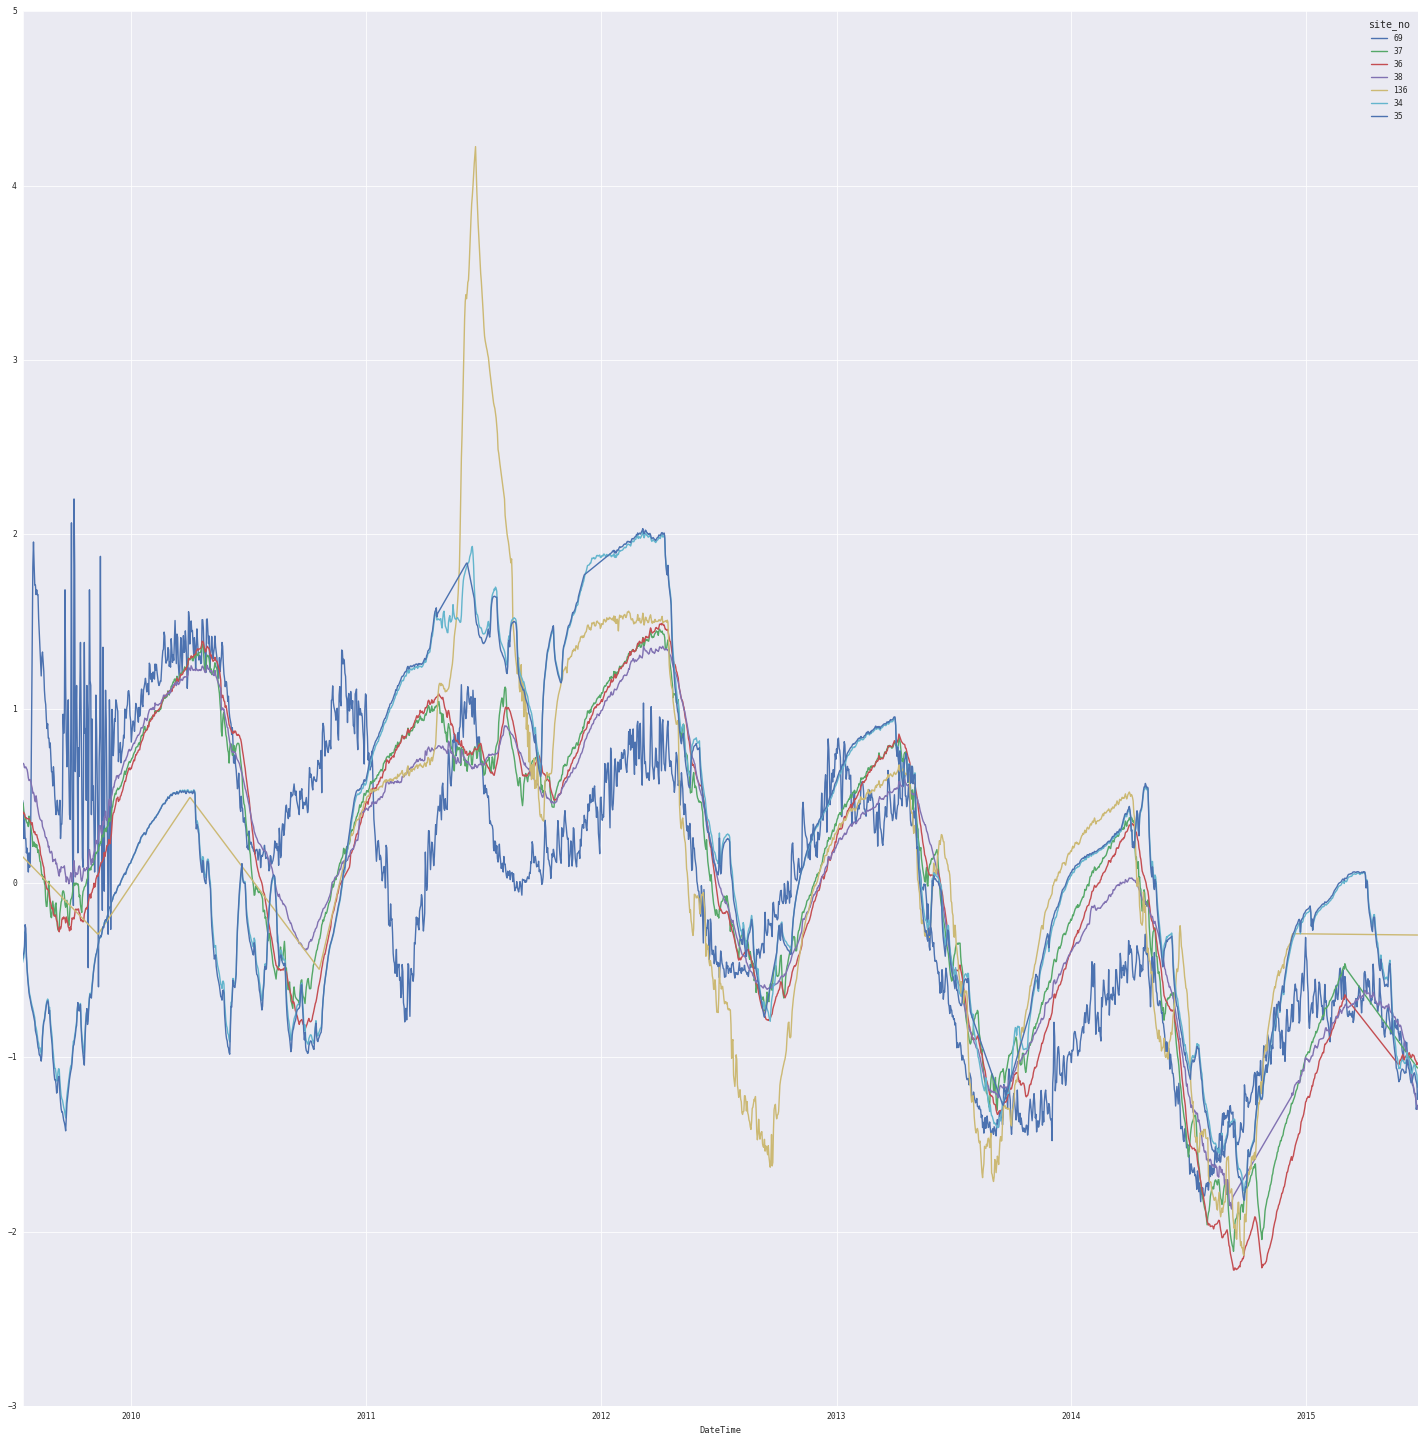

In [83]:
d[[69,37,36,38,136,34,35]].plot()

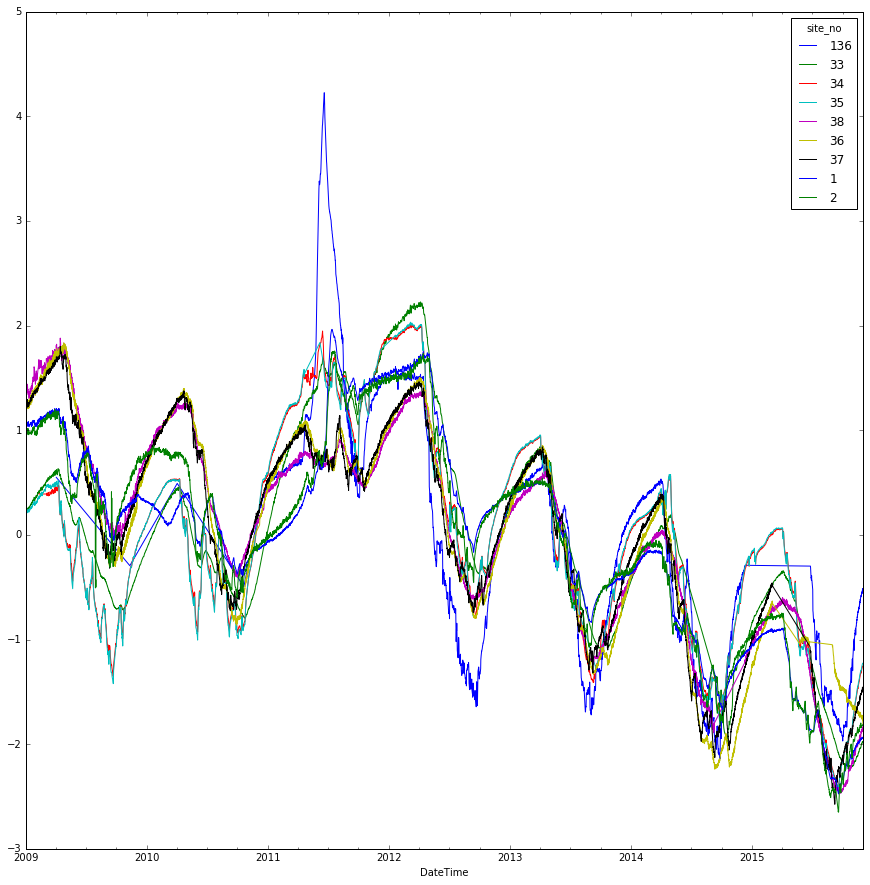

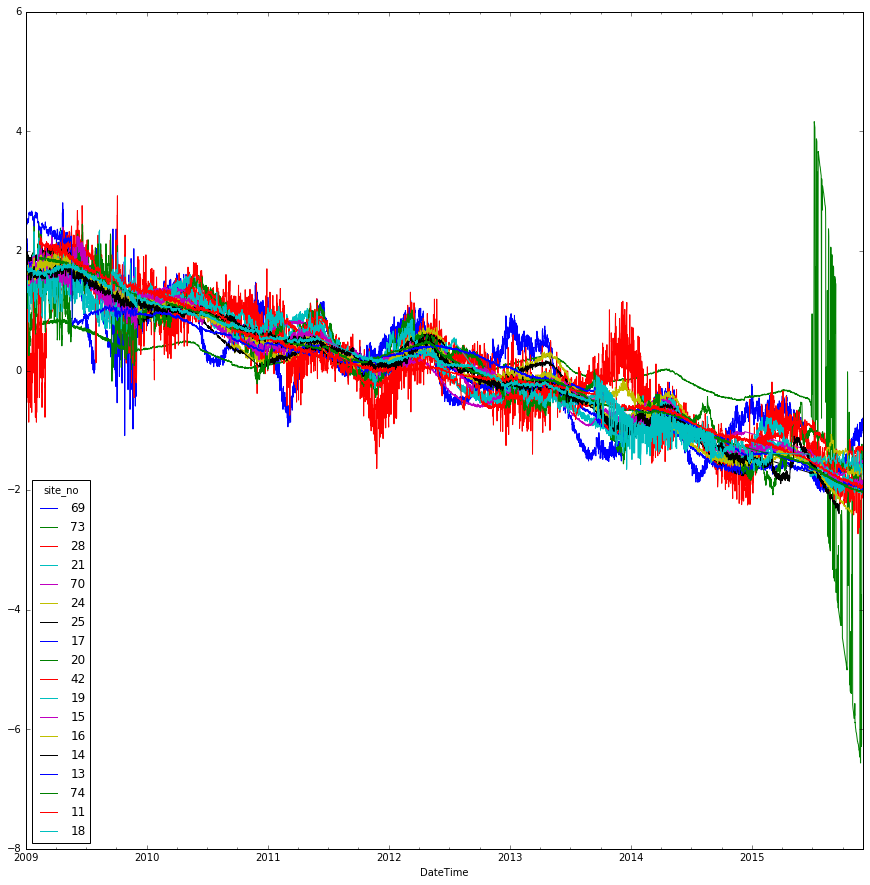

In [51]:
d[[136,33,34,35,38,36,37,1,2]].plot()
d[[69,73,28,21,70,24,25,17,20,42,19,15,16,14,13,74,11,18]].plot()

In [96]:
A1 = [59,58,60,63,68,41,67,61,64]
A2 = [136,33,34,35,72,39,57,66,5,62,4,71,40,65]
B1 = [55,52,53,6,7,8,12,54]
B2 = [3,47]
B3 = [28,13,24,25,20,19,74,15,16,11,14,18,17,42,21,70]
B4 = [73,22,23,30,29,31,1,2,69,38,36,37]
C1 = [27,26,9,10]
C2 = [32,48,51,49,50,45,46,56,43,44,75]
ClustGroups = [A1,A2,B1,B2,B3,B4,C1,C2]

In [103]:
fc = {}
grpNames = ['A1','A2','B1','B2','B3','B4','C1','C2']
for i in range(len(ClustGroups)):
    fc[grpNames[i]] = [wellid[j] for j in ClustGroups[i]]

In [55]:
d.columns

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
             14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
             27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
             40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
             53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
             66,  67,  68,  69,  70,  71,  72,  73,  74,  75, 136],
           dtype='int64', name=u'site_no')

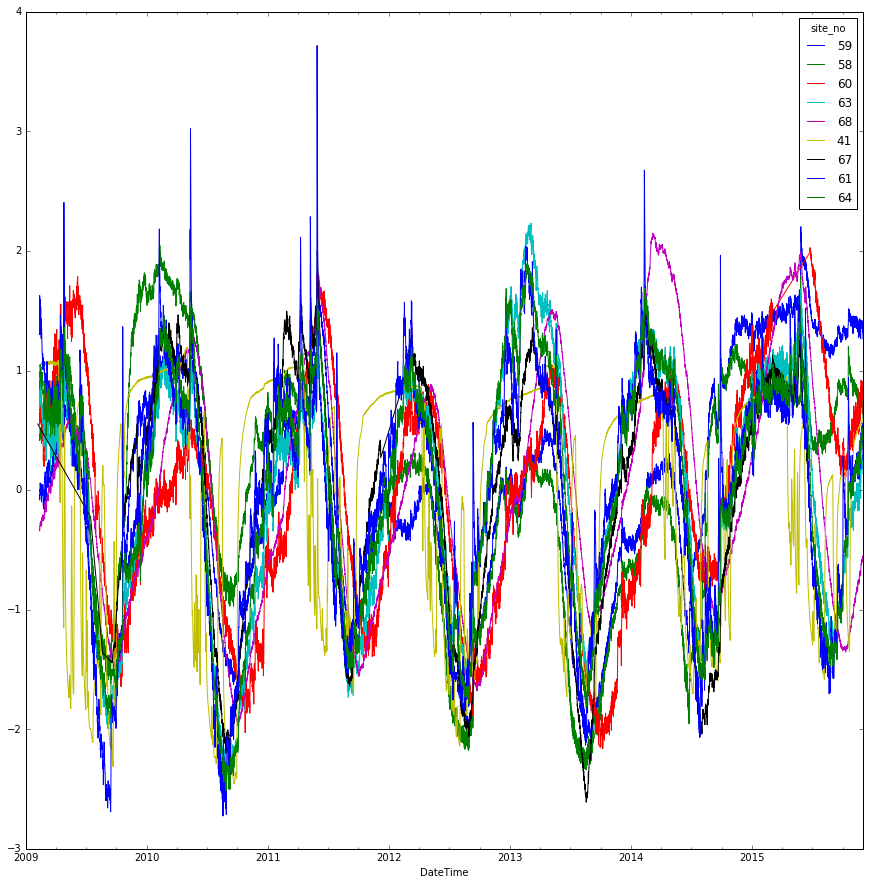

In [74]:

rcParams['figure.figsize'] = 15, 15
d[[59,58,60,63,68,41,67,61,64]].plot()


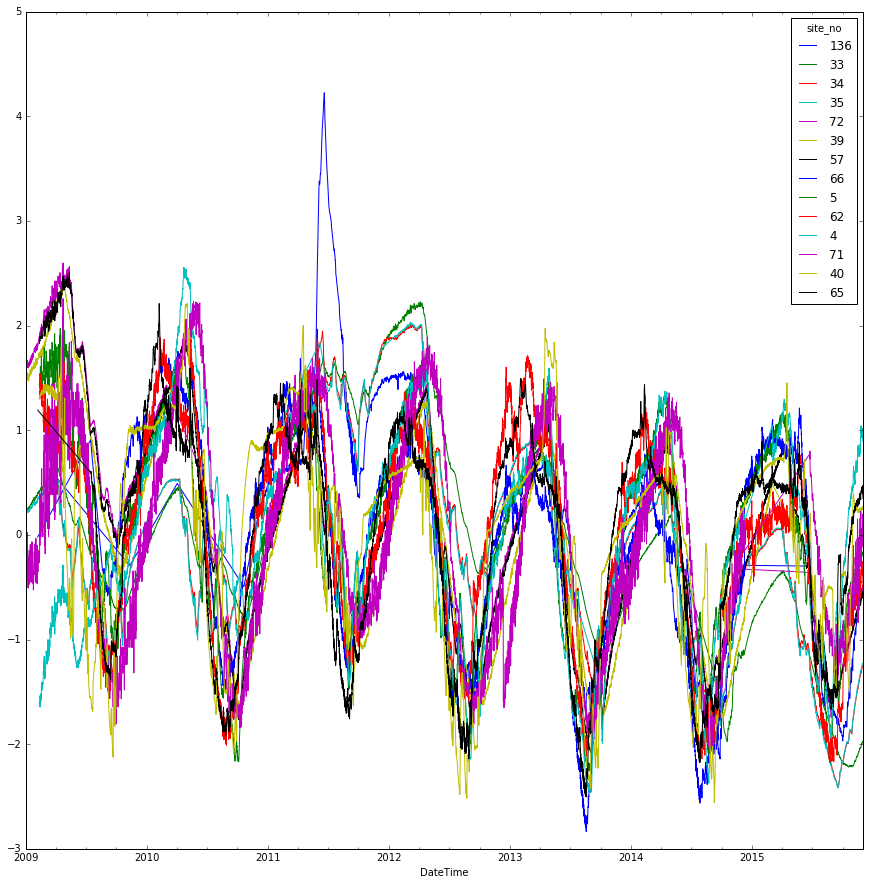

In [75]:
d[[136,33,34,35,72,39,57,66,5,62,4,71,40,65]].plot()

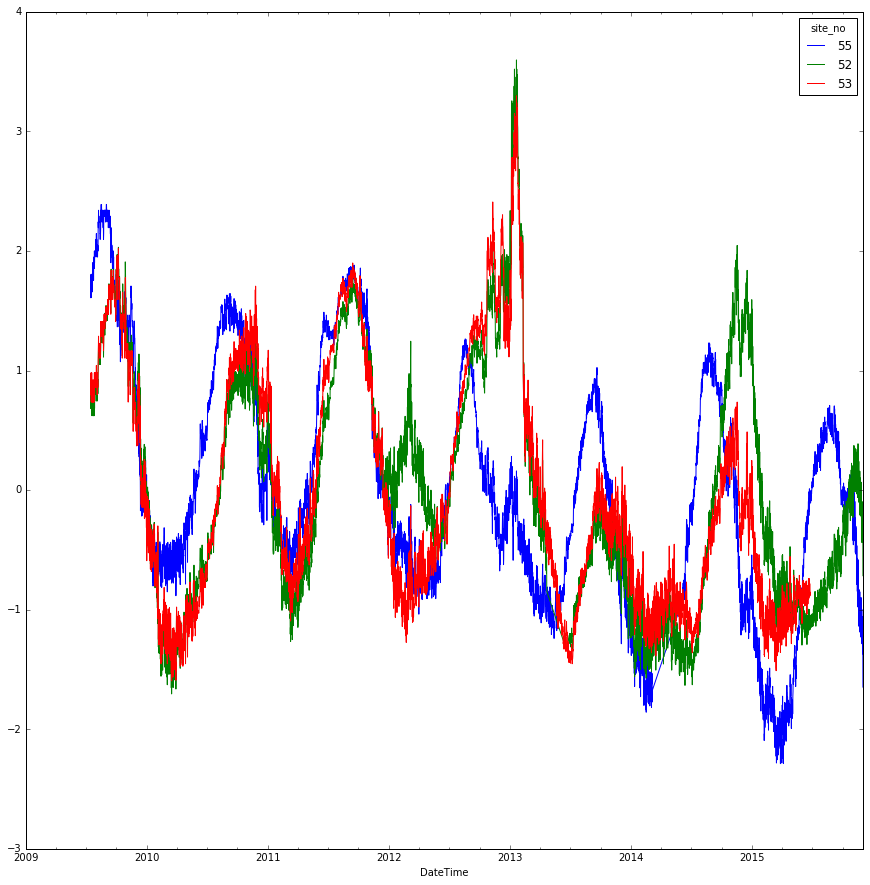

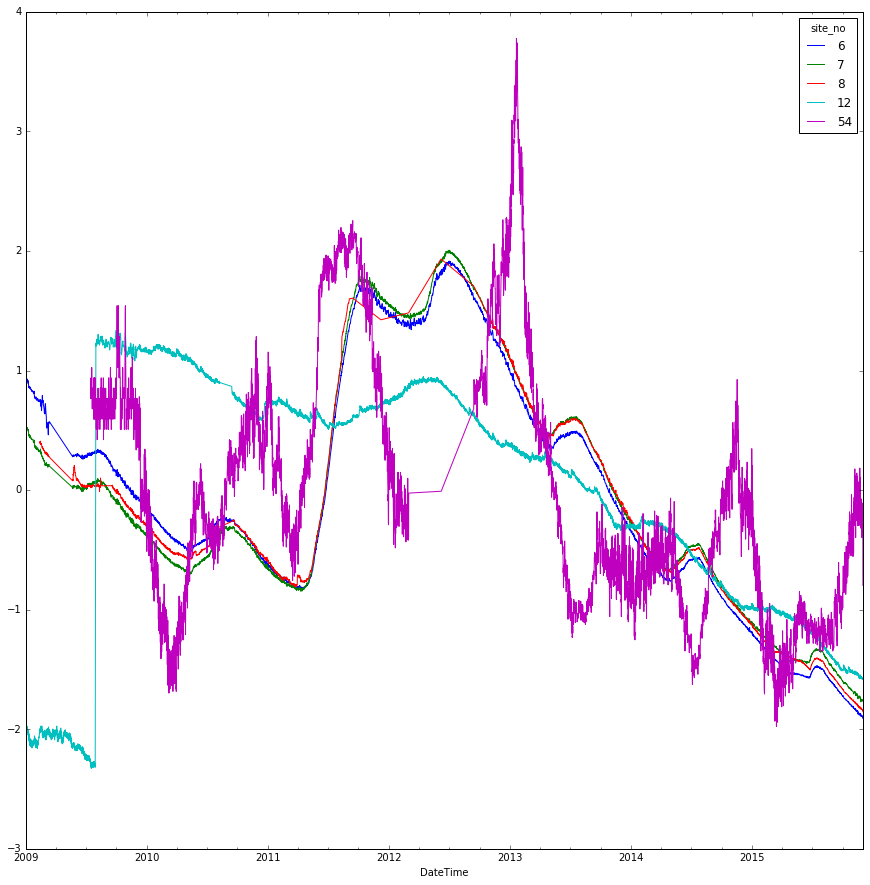

In [79]:
d[[55,52,53]].plot()
d[[6,7,8,12,54]].plot()

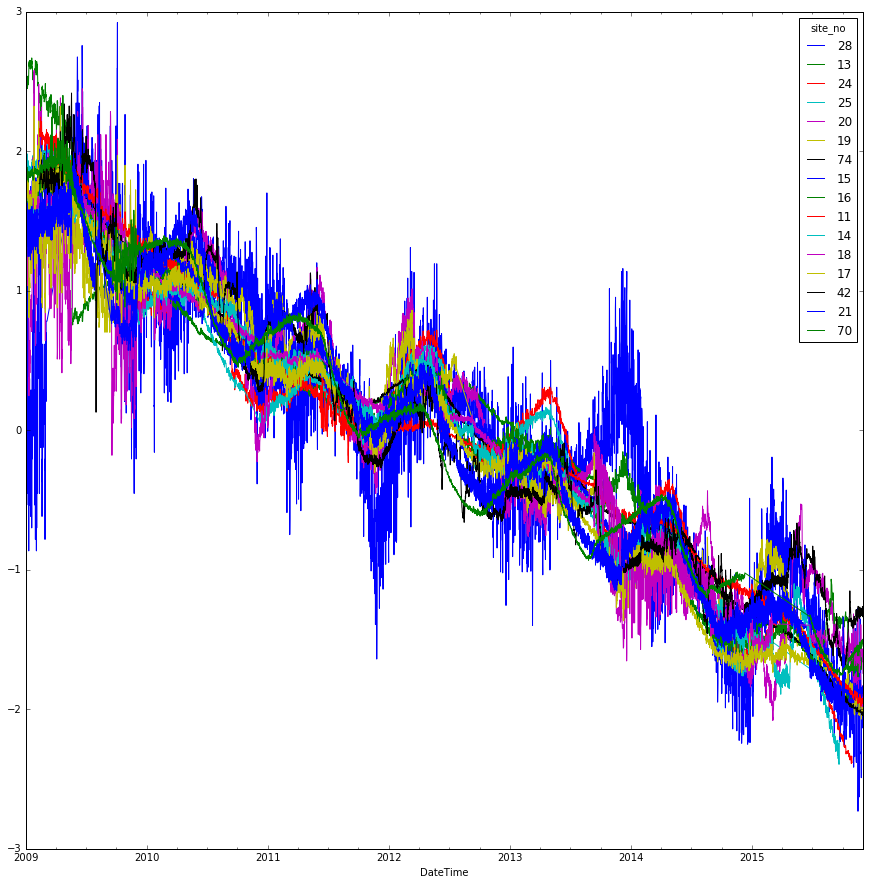

In [80]:
d[[28,13,24,25,20,19,74,15,16,11,14,18,17,42,21,70]].plot()

In [108]:
fc['B3']

['PW11B',
 'PW05C',
 'PW09A',
 'PW09B',
 'PW07B',
 'PW07A',
 'Baker Creek',
 'PW06B',
 'PW06C',
 'PW05A',
 'PW06A',
 'PW06MX',
 'PW06D',
 'AG16C',
 'PW07MX',
 'Snake Valley North MX']

In [98]:
A1

[59, 58, 60, 63, 68, 41, 67, 61, 64]

In [58]:
wellid[3]

'PW01C'

IBAH Snow Depth
Eskd Snow Depth
Fish Snow Depth
Part Snow Depth
Calo Snow Depth


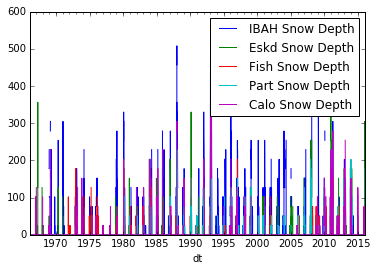

In [37]:

for column in IBEFPC.columns:
    if ' Snow Depth' in column:
        print(column)
        IBEFPC[column].plot(label=column)
        plt.legend()

http://wcc.sc.egov.usda.gov/nwcc/sensors

In [ ]:
TuleDaily[u'SMS.I-1:-40 (pct)  (loam)'].plot()

In [ ]:
PW17B = df[df.site_no==44]
CentTuleMX = df[df.site_no==75]

In [ ]:
PW17andTule = pd.merge(PW17B, TuleDaily, left_index=True, right_index=True, how='inner' )
TuleandTule = pd.merge(CentTuleMX, TuleDaily, left_index=True, right_index=True, how='inner' )

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
y1 = PW17andTule.lev_va
y2 = PW17andTule[u'SMS.I-1:-4 (pct)  (loam)']
x = PW17andTule.index


ax1.plot(x,y1,color='red', label='PW17B water level')

ax2.plot(x,y2,color='blue', label='soil moisture Tule')
#plt.legend()

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
y1 = TuleandTule.lev_va
y2 = TuleandTule[u'SMS.I-1:-20 (pct)  (loam)']
x = TuleandTule.index


ax1.plot(x,y1,color='red', label='PW17B water level')

ax2.plot(x,y2,color='blue', label='soil moisture Tule')
#plt.legend()

In [ ]:
Whlr['WTEQ.I-1 (in) '].plot()

In [ ]:
WhlrDaily = Whlr.resample('D', how='mean')

In [ ]:
TuleFile = outputFolder + "UCC_ghcn_USR0000TULE_2016_03_06_1457300476.csv"
EskdaleFile = outputFolder + "UCC_ghcn_USC00422607_2016_03_06_1457300462.csv"
PartoonFile = outputFolder + "UCC_ghcn_USC00426708_2016_03_02_1456937496.csv"

Partoon = pd.read_csv(PartoonFile, na_values=['M','S', 'T'], skiprows=15, index_col=0, parse_dates=True)
Tule = pd.read_csv(TuleFile, na_values=['M','S', 'T'], skiprows=15, index_col=0, parse_dates=True)
Eskdale = pd.read_csv(EskdaleFile, na_values=['M','S', 'T'], skiprows=15, index_col=0, parse_dates=True)

Partoon = Partoon[Partoon.index > pd.datetime(1949,1,1)]

Partoon = Partoon.fillna(0)
Eskdale = Eskdale.fillna(0)

In [ ]:
def cumdept(df, prec='Precipitation'):
    df['date'] = df.index
    df['month'] = df.date.apply(lambda x: x.month, 1)
    df['dept'] = df[prec].apply(lambda x: x - df[prec].mean(),1)
    df['cumDept'] = df['dept'].cumsum()
    return df

In [ ]:
Partoon = cumdept(Partoon)
Eskdale = cumdept(Eskdale)

In [ ]:
Partoon['cumDept'].plot()
Eskdale['cumDept'].plot()

In [ ]:
url = 'http://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/daily/1147:NV:SNTL%7Cid=%22%22%7Cname/POR_BEGIN,POR_END/WTEQ::value,PREC::value,TMAX::value,TMIN::value,TAVG::value,PRCP::value'

In [ ]:
SNOTEL = pd.read_csv(url, skiprows=7, index_col=0 )

In [ ]:
SNOTEL.columns

In [ ]:
Eskdale['Precipitation'].plot()

In [ ]:
SNOTEL['Snow Water Equivalent (in)'].plot()

In [ ]:
def pptmonthlyPlot(df, grp, data, title):
    grpd = df.groupby([grp])[data]
    x = grpd.median().index
    y = grpd.mean()
    y1 = grpd.quantile(q=0.25)
    y2 = grpd.quantile(q=0.75)
    y3 = grpd.quantile(q=0.1)
    y4 = grpd.quantile(q=0.9)
    
    n = plt.figure()
    plt.plot(x, y, 'bo-',color = 'blue', label = 'Median', )
    plt.fill_between(x,y2,y1,alpha=0.2, label = '25-75%-tiles', color = 'green')
    plt.fill_between(x,y3,y1,alpha=0.2, color='red', label = '10-90%-tiles')
    plt.fill_between(x,y2,y4,alpha=0.2, color='red')
    if grp == 'month':
        plt.xlim(0,13)
        plt.xticks(range(0,13))
    #plt.ylim(-2.25,2.25)
    #plt.yticks(np.arange(-2.25,2.50,0.25))
        plt.xlabel('month')
    plt.ylabel(title)
    plt.grid()
    plt.legend(loc=3)
    
    return n


grp = 'month'
#pd.TimeGrouper("M")

data = 'cumDept'
title = 'Precip'
pptmonthlyPlot(pPPT, grp, data, title)
plt.title('Partoon')enerator/view_csv/customSingleStationReport/daily/1147:NV:SNTL%7C


In [ ]:
SNO = pd.read_csv(outputFolder+"1247_ALL_YEAR=2013.csv",skiprows=3, parse_dates={'datetime':[1,2]}, index_col='datetime')

In [ ]:
SNO[u'WTEQ.I-1 (in) '].plot()


In [ ]:
SNO2 = wa.transport.smoother(SNO, u'WTEQ.I-1 (in) ')

In [ ]:
SNO2[u'WTEQ.I-1 (in) '].plot()

In [ ]:
df.reset_index(inplace=True)

In [ ]:
import scipy
from scipy.stats import norm
def mk_ts(df, const, group1, orderby = 'year', alpha = 0.05):
    '''
    df = dataframe
    const = variable tested for trend
    group1 = variable to group by
    orderby = variable to order by (typically a date)
    '''
    
    def mk_test(x, alpha):
        """
        this perform the MK (Mann-Kendall) test to check if there is any trend present in 
        data or not

        Input:
            x:   a vector of data
            alpha: significance level

        Output:
            trend: tells the trend (increasing, decreasing or no trend)
            h: True (if trend is present) or False (if trend is absence)
            p: p value of the sifnificance test
            z: normalized test statistics 

        Examples
        --------
          >>> x = np.random.rand(100)
          >>> trend,h,p,z = mk_test(x,0.05) 

        Credit: http://pydoc.net/Python/ambhas/0.4.0/ambhas.stats/
        """
        n = len(x)
        ta = n*(n-1)/2
        # calculate S 
        s = 0
        for k in xrange(n-1): # this does not work with nan values
            for j in xrange(k+1,n):
                s += np.sign(x[j] - x[k])

        # calculate the unique data
        unique_x = np.unique(x)
        g = len(unique_x)

        # calculate the var(s)
        if n == g: # there is no tie
            var_s = (n*(n-1)*(2*n+5))/18
        else: # there are some ties in data
            tp = np.zeros(unique_x.shape)
            for i in xrange(len(unique_x)):
                tp[i] = sum(unique_x[i] == x)
            var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18
        
        # calculate z value
        if s > 0.0:
            z = (s - 1)/np.sqrt(var_s)
        elif s == 0.0:
            z = 0
        elif s < 0.0:
            z = (s + 1)/np.sqrt(var_s)
        else:
            print('problem with s')

        # calculate the p_value
        p = 2*(1-norm.cdf(abs(z))) # two tail test
        h = abs(z) > norm.ppf(1-alpha/2) 

        if (z<0) and h:
            trend = 'decreasing'
        elif (z>0) and h:
            trend = 'increasing'
        else:
            trend = 'no trend'

        return pd.Series({'trend':trend, 'varS':round(var_s,3), 'p':round(p,3), 'z':round(z,3), 's':round(s,3), 'n':n, 'ta':ta})

    def zcalc(Sp, Varp):
        if Sp > 0:
            return (Sp - 1)/Varp**0.5
        elif Sp < 0:
            return (Sp + 1)/Varp**0.5
        else:
            return 0   
    
    df.is_copy = False
    
    df[const] = pd.to_numeric(df.ix[:,const])
    # remove null values
    df[const].dropna(inplace=True)
    # remove index
    df.reset_index(inplace=True, drop=True)
    # sort by groups, then time
    df.sort_values(by=[group1,orderby],axis=0, inplace=True)
    
    # group by group and apply mk_test
    dg = df.groupby(group1).apply(lambda x: mk_test(x.loc[:,const].dropna().values, alpha))
    Var_S = dg.loc[:,'varS'].sum()
    S = dg.loc[:,'s'].sum()
    N = dg.loc[:,'n'].sum()
    Z = zcalc(S,Var_S)
    P = 2*(1-norm.cdf(abs(Z)))
    group_n = len(dg)
    h = abs(Z) > norm.ppf(1-alpha/2) 
    tau = S/dg.loc[:,'ta'].sum()

    if (Z<0) and h:
        trend = 'decreasing'
    elif (Z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
    
    
    return pd.Series({'S':S, 'Z':round(Z,2), 'p':P, 'trend':trend, 'group_n':group_n, 'sample_n':N, 'Var_S':Var_S, 'tau':round(tau,2)})

In [ ]:
def USGSchemTab(df,chem,group, alpha=0.1):
    def func(y,x):
        # make conc nulls match value nulls
        if np.isnan(x)==True:
            return np.nan
        elif y=='<':
            return 0
        else:
            return 1
    
    def sigtest(x, c):
        if x >= alpha:
            np.nan
        elif c < 0:
            return '(-)'
        else:
            return '(+)'
    df.is_copy = False
    
    df[chem+'cond'] = usgs.apply(lambda df: func(df[chem+'rem'],df[chem]),axis=1)
    df[chem+'cond1'] = usgs.apply(lambda df: func(df[chem+'rem1'],df[chem]),axis=1)
    
    df.set_index([group],inplace=True)
    unit = df.index.get_level_values(0).unique()
    
    network,n,T1,p1,chng = [],[],[],[],[]
    for i in unit:
        network.append(i)
        n.append(len(df.loc[i,chem]))
        T1.append(scipy.stats.wilcoxon(df.loc[i,chem].values,df.loc[i,chem+'1'].values, zero_method='zsplit')[0])
        p1.append(scipy.stats.wilcoxon(df.loc[i,chem].values,df.loc[i,chem+'1'].values, zero_method='zsplit')[1])
        chng.append(round((df.loc[i,chem+'1'] - df.loc[i,chem]).median(),2))
    refdict = {'ntwrk':network,'n':n,'T':T1,'p':p1,'chng':chng}
    df.reset_index(inplace=True)
    Nresframe = pd.DataFrame(refdict)
    Nresframe.is_copy = False
    Nresframe['signif'] = Nresframe[['p','chng']].apply(lambda x: sigtest(x[0],x[1]),1)
    
    return Nresframe

In [ ]:
df.columns

In [ ]:
#dfs.drop('level_0', axis=1, inplace=True)
dfs.reset_index(inplace=True)
combo, names = [],[]
# we gill group stations by network to analyze each network.
for k, v in dfs.groupby('MonType'):
    combo.append(mk_ts(v, 'lev_va','site_no','lev_dt', 0.10))
    names.append(k)
pd.DataFrame(combo, index=names)

In [ ]:
combo, names = [],[]
# we gill group stations by network to analyze each network.
for k, v in df.groupby('MonType'):
    combo.append(mk_ts(v, 'lev_va','site_no','lev_dt', 0.10))
    names.append(k)
pd.DataFrame(combo, index=names)

In [ ]:
import statsmodels.api as sm

In [ ]:
from statsmodels.graphics.api import qqplot

In [ ]:
d = []
for k, v in dfs.groupby('MonType'):
    d.append(sm.stats.stattools.durbin_watson(v.lev_va.values))
d

In [ ]:
df.lev_va.values
dfs = df.dropna(subset=['lev_va'])

In [ ]:
for k, v in dfs.groupby('site_no'):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(v.lev_va.values.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(v.lev_va, lags=40, ax=ax2)

In [ ]:
#dfs.drop('level_0', axis=1, inplace=True)
dfs.reset_index(inplace=True)
dfs.set_index("lev_dt",inplace=True)
yearMonitorType = dfs.groupby(['MonType','site_no',"Year"])['lev_va'].median().to_frame()

In [ ]:
types = list(yearMonitorType.index.levels[0])

d = []
for t in types:
    d.append(sm.stats.stattools.durbin_watson(yearMonitorType.loc[t,:].values))
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(yearMonitorType.loc[t,:].values.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(yearMonitorType.loc[t,:].values, lags=40, ax=ax2)
d

In [ ]:
monthly = LongStats.groupby(['site_no',pd.TimeGrouper("M")])['lev_va'].agg({'mean':np.mean,'median':np.median,
                                                                'standard':np.std, 'cnt':(lambda x: np.count_nonzero(np.isfinite(x))), 
                                                                'err':(lambda x: 1.96*wa.avgMeths.sumstats(x))})
weekly = LongStats.groupby(['site_no',pd.TimeGrouper("W")])['lev_va'].agg({'mean':np.mean,'median':np.median,
                                                                'standard':np.std, 'cnt':(lambda x: np.count_nonzero(np.isfinite(x))), 
                                                                'err':(lambda x: 1.96*wa.avgMeths.sumstats(x))})

In [ ]:
sites = pd.read_excel("M:\GIS\site.xlsx")

In [ ]:
monthly.reset_index(inplace=True)

In [ ]:
weekly.reset_index(inplace=True)

In [ ]:
print(monthly.columns,sites.columns) 

In [ ]:
monthlyData = pd.merge(monthly,sites, left_on='site_no', right_on='WellID', how='left')
monthlyData.to_csv("M:\GIS\monthlyData.csv")

In [ ]:
x = LongStats.groupby(pd.TimeGrouper("M"))['stdWL'].median().index
y = LongStats.groupby(pd.TimeGrouper("M"))['stdWL'].median()
y1 = LongStats.groupby(pd.TimeGrouper("M"))['stdWL'].quantile(q=0.25)
y2 = LongStats.groupby(pd.TimeGrouper("M"))['stdWL'].quantile(q=0.75)
y3 = LongStats.groupby(pd.TimeGrouper("M"))['stdWL'].quantile(q=0.1)
y4 = LongStats.groupby(pd.TimeGrouper("M"))['stdWL'].quantile(q=0.9)

plt.plot(x, y, color = 'blue', label = 'Median')
#plt.xlim(200800,201600)
#plt.ylim(-5,5)
#plt.plot(x, y1, color = 'red', label = '25%-tile')
#plt.plot(x, y2, color = 'red', label = '75%-tile')
plt.fill_between(x,y2,y1,alpha=0.2, label = '25-75%-tiles', color = 'green')
plt.fill_between(x,y3,y1,alpha=0.2, color='red', label = '10-90%-tiles')
plt.fill_between(x,y2,y4,alpha=0.2, color='red')
plt.grid()
plt.legend()
plt.show()

In [ ]:

wlLongStatsGroups = wlLongStats.groupby(['date'])['stdWL'].agg({'mean':np.mean,'median':np.median,
                                                                'standard':np.std, 'cnt':(lambda x: np.count_nonzero(np.isfinite(x))), 
                                                                'err':(lambda x: 1.96*wa.avgMeths.sumstats(x))})
wlLongStatsGroups2 = wlLongStats.groupby(['date'])['levDiff'].agg({'mean':np.mean,'median':np.median, 'standard':np.std, 'cnt':(lambda x: np.count_nonzero(~np.isnan(x))), 
                                                                   'err':(lambda x: 1.96*wa.avgMeths.sumstats(x))})

wlLongStatsGroups['meanpluserr'] = wlLongStatsGroups['mean'] + wlLongStatsGroups['err']
wlLongStatsGroups['meanminuserr'] = wlLongStatsGroups['mean'] - wlLongStatsGroups['err']

wlLongStatsGroups2['meanpluserr'] = wlLongStatsGroups2['mean'] + wlLongStatsGroups2['err']
wlLongStatsGroups2['meanminuserr'] = wlLongStatsGroups2['mean'] - wlLongStatsGroups2['err']

In [ ]:
x = wlLongStats.groupby(['date'])['stdWL'].median().index.values
y = wlLongStats.groupby(['date'])['stdWL'].median().values
y1 = wlLongStats.groupby(['date'])['stdWL'].quantile(q=0.25).values
y2 = wlLongStats.groupby(['date'])['stdWL'].quantile(q=0.75).values


plt.plot(x, y)
plt.plot(x, y1)
plt.plot(x, y2)
plt.fill_between(x,y2,y1,alpha=0.5)

In [ ]:
TallDaily = AllDaily.pivot(index='DateTime',columns='level_0',values='WaterElevation')

In [ ]:
UnstackedDaily = AllDaily.unstack(0)

In [ ]:
UnstackedDaily['WaterElevation'][range(1,20)].plot()


In [ ]:
daily[5].plot()

In [ ]:
g.drop(g.columns[0],inplace=True,axis=1)

In [ ]:
g